In [1]:
import os
from operator import itemgetter

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from caveclient import CAVEclient
from standard_transform import minnie_transform_nm

import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

In [5]:
MINNIE_DATASTACK = "minnie65_public_v343"
# client = CAVEclient(MINNIE_DATASTACK)
client = CAVEclient(MINNIE_DATASTACK, desired_resolution=[1, 1, 1])

In [5]:
nm_transform = minnie_transform_nm()
nm_transform

Transformation Sequence:
	Rotate with params ('z', 5) and {'degrees': True}
	Translate by [      0.         -396671.03221028       0.        ]
	Scale by [[0.001 0.001 0.001]]

In [27]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

# Plot neuron soma positions

In [6]:
nucleus_neuron_svm = client.materialize.query_table("nucleus_neuron_svm")
nucleus_neuron_svm

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1,t,is_neuron,not-neuron,0,0,"[243200.0, 307648.0, 792760.0]"
1,33,t,is_neuron,not-neuron,0,0,"[225280.0, 308800.0, 954800.0]"
2,133,t,is_neuron,not-neuron,0,0,"[248256.0, 357568.0, 775400.0]"
3,146,t,is_neuron,not-neuron,0,0,"[249600.0, 362112.0, 776120.0]"
4,162,t,is_neuron,not-neuron,0,0,"[253568.0, 345472.0, 775960.0]"
...,...,...,...,...,...,...,...
171810,421067,t,is_neuron,neuron,100210315664641158,864691135463007294,"[1030336.0, 399168.0, 999040.0]"
171811,421085,t,is_neuron,not-neuron,100421078299751587,864691135463007294,"[1036800.0, 387904.0, 1002240.0]"
171812,669991,t,is_neuron,neuron,115353958167851692,864691135065309764,"[1471808.0, 826688.0, 1040160.0]"
171813,427907,t,is_neuron,neuron,99304248558546493,864691135341366469,"[1004288.0, 658304.0, 746400.0]"


In [7]:
nucleus_neuron_svm.attrs

{'datastack_name': 'minnie65_public_v343',
 'join_query': False,
 'table_name': 'nucleus_neuron_svm__minnie3_v1',
 'table_created': '2020-11-13T18:35:29.959876',
 'table_id': 8321,
 'table_valid': True,
 'table_schema': 'cell_type_local',
 'table_aligned_volume': 'minnie65_phase3',
 'table_schema_type': 'cell_type_local',
 'table_user_id': '121',
 'table_description': 'This table contains a prediction about what nucleus detections are neurons and which are likely not neurons.  This is based upon a model trained by Leila Elabbady (Allen Institute) on nucleus segmentations in Basil, processed for features such as volume, foldedness, location in cortex, etc, and applied to Minnie65.  In Basil the model had a cross validated f1 score of .97 and a recall of .97 for neurons.  Manual validation performed on a column of 1316 nuclei in Minnie65 measured a recall of .996 and a precision of .969. ',
 'table_notice_text': 'Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table

In [8]:
neuron_pos_nm = np.vstack(nucleus_neuron_svm.pt_position.values[nucleus_neuron_svm.cell_type == "neuron"])
neuron_pos_microns = nm_transform.apply(neuron_pos_nm)

In [71]:
# LAYER_BOUNDARIES = [100, 375, 550, 750, 800]
LAYER_BOUNDARIES = [90, 255, 370, 525, 700]
LAYER_NAMES = ["2/3", "4", "5", "6"]

def add_layer_lines(ax):
    for i, depth in enumerate(LAYER_BOUNDARIES):
        ax.axhline(depth, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
        ax.text(1, depth, f"{depth} µm", ha="left", va="center", color="red", fontsize=10, transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

        if i < len(LAYER_NAMES):
            layer = LAYER_NAMES[i]
            layer_text_y = depth + (LAYER_BOUNDARIES[i+1]-depth)/2
            ax.text(1, layer_text_y, f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

def get_layer_min_max_depth(layer):
    if type(layer) is int:
        layer = str(layer)
    
    # if layer == "23" or layer == "2/3":
    #     return LAYER_BOUNDARIES[LAYER_NAMES.index("2")], LAYER_BOUNDARIES[LAYER_NAMES.index("3")+1]
    
    if layer in LAYER_NAMES:
        i = LAYER_NAMES.index(layer)
        return LAYER_BOUNDARIES[i], LAYER_BOUNDARIES[i+1]
    
    raise ValueError(f"Bad layer: {layer}")

def is_in_layer(pos, layer, boundary_padding=25):
    min_depth, max_depth = get_layer_min_max_depth(layer)
    min_depth -= boundary_padding
    max_depth += boundary_padding

    if isinstance(pos, pd.Series):
        return pos.apply(lambda p: min_depth <= p[1] <= max_depth)
    elif isinstance(pos, np.ndarray) and len(pos.shape) == 2:
        return (min_depth <= pos[:,1]) & (pos[:,1] <= max_depth)
    else:
        return min_depth <= pos[1] <= max_depth

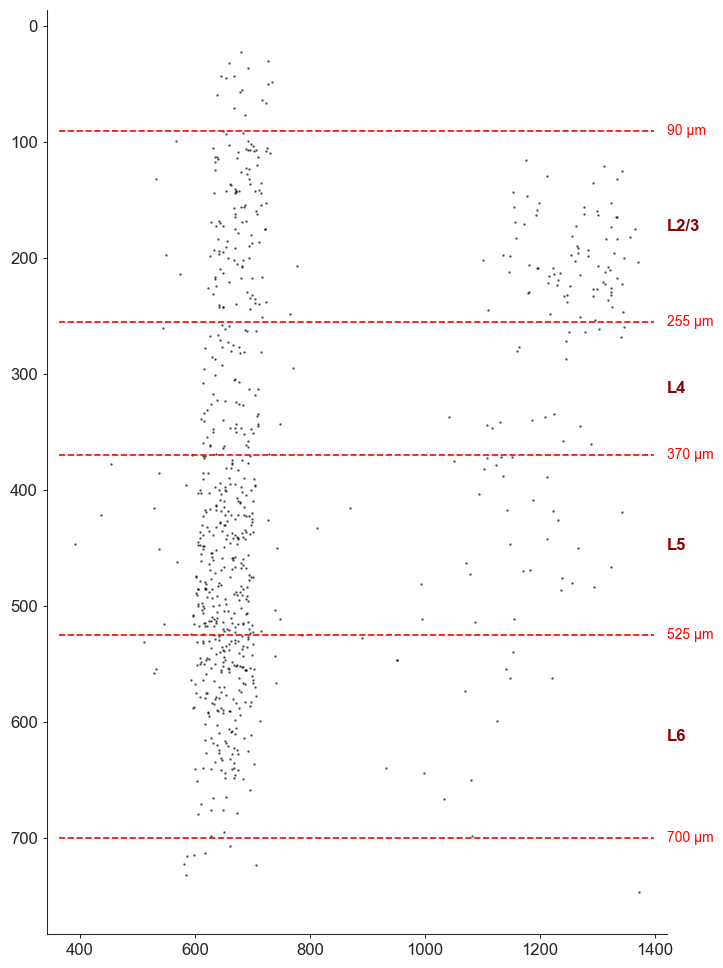

In [72]:
fig, ax = plt.subplots(figsize=(8, 12))
ax.scatter(neuron_pos_microns[:, 0], neuron_pos_microns[:, 1], s=1, color="black", alpha=0.5)
# ax.scatter(neuron_pos_nm[:, 0], neuron_pos_nm[:, 1], s=1, color="black", alpha=0.5)
ax.invert_yaxis()
add_layer_lines(ax)

# Do the same for the `nucleus_detection_v0` table

In [12]:
nucleus_detection = client.materialize.query_table("nucleus_detection_v0")
nucleus_detection

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,11294,t,49.112842,73556435283294116,864691135269406572,"[255872.0, 872128.0, 827320.0]","[nan, nan, nan]","[nan, nan, nan]"
1,11300,t,323.577446,73626116832723681,864691135151717168,"[257600.0, 852288.0, 825200.0]","[nan, nan, nan]","[nan, nan, nan]"
2,11301,t,277.511864,0,0,"[257984.0, 876416.0, 816320.0]","[nan, nan, nan]","[nan, nan, nan]"
3,11303,t,352.645775,0,0,"[258944.0, 854720.0, 816640.0]","[nan, nan, nan]","[nan, nan, nan]"
4,11310,t,89.947668,0,0,"[259968.0, 877376.0, 830920.0]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...
144115,505628,t,117.035991,103751017984006584,864691136266769396,"[1133696.0, 1062336.0, 999200.0]","[nan, nan, nan]","[nan, nan, nan]"
144116,505756,t,102.715228,104524387109422316,864691136266769396,"[1155840.0, 1041984.0, 1039200.0]","[nan, nan, nan]","[nan, nan, nan]"
144117,599327,t,85.607219,110154023814137181,864691136266769396,"[1319936.0, 1046656.0, 960080.0]","[nan, nan, nan]","[nan, nan, nan]"
144118,589181,t,545.759887,110846784724605457,864691136594841250,"[1341056.0, 720000.0, 901760.0]","[nan, nan, nan]","[nan, nan, nan]"


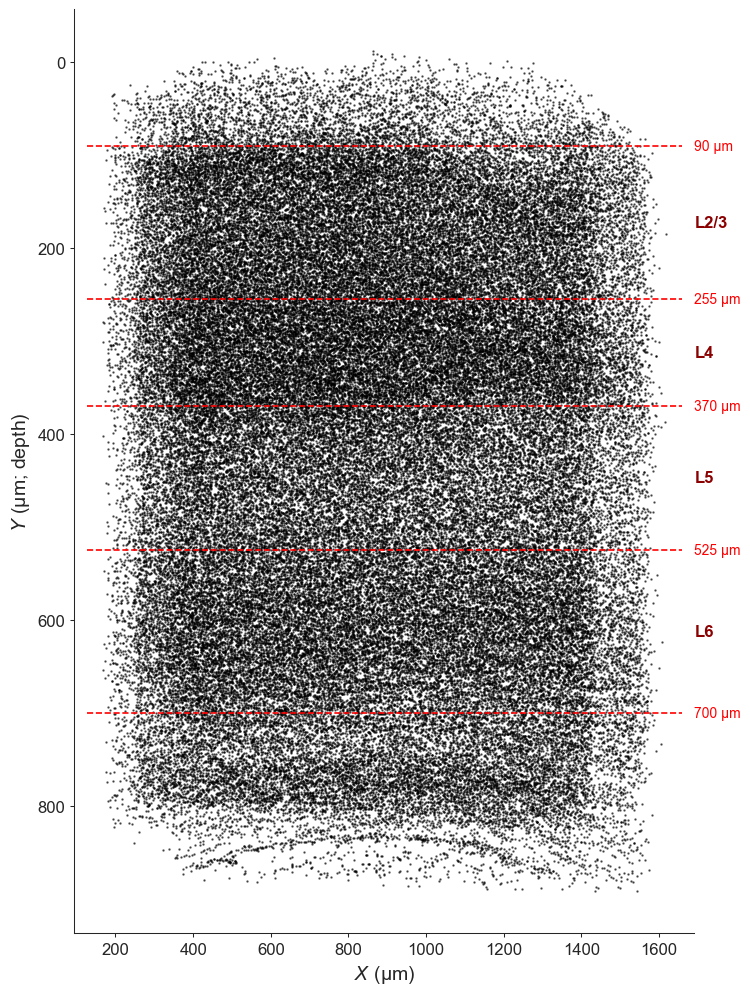

In [73]:
neuron_pos_nm = np.vstack(nucleus_detection.drop_duplicates("pt_root_id").pt_position.values)
neuron_pos_microns = nm_transform.apply(neuron_pos_nm)

fig, ax = plt.subplots(figsize=(8, 12))
ax.scatter(neuron_pos_microns[:, 0], neuron_pos_microns[:, 1], s=1, color="black", alpha=0.5)
# ax.scatter(neuron_pos_nm[:, 0], neuron_pos_nm[:, 1], s=1, color="black", alpha=0.5)
ax.invert_yaxis()
# ax.set_yticks(list(range(300, 1200, 50)))
ax.set_xlabel("$X$ (µm)")
ax.set_ylabel("$Y$ (µm; depth)")
add_layer_lines(ax)

# for y in (100, 375, 550, 750, 800):
#     ax.axhline(y, color="red", linestyle="dashed")

# Look at proofreading

In [25]:
proofreading_table = client.materialize.query_table("proofreading_status_public_release")
proofreading_table

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[765696.0, 839552.0, 913800.0]"
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[779456.0, 864512.0, 888200.0]"
2,8,t,90444453118345856,864691135866846742,864691135866846742,extended,non,"[747072.0, 857152.0, 912440.0]"
3,9,t,89741246779911895,864691135445832338,864691135445832338,extended,non,"[725248.0, 871616.0, 930040.0]"
4,13,t,91499640750531825,864691135569255558,864691135569255558,extended,non,"[776448.0, 848256.0, 927000.0]"
...,...,...,...,...,...,...,...,...
759,870,t,90518464128858597,864691136594839202,864691136594839202,clean,clean,"[747712.0, 966976.0, 948720.0]"
760,871,t,91712464970366508,864691136175508486,864691136175508486,clean,clean,"[782976.0, 898432.0, 940000.0]"
761,736,t,110706459687342783,864691136617461979,864691136617461979,extended,extended,"[1335552.0, 733184.0, 943920.0]"
762,154,t,89456404347350172,864691135334665705,864691135334665705,extended,non,"[717824.0, 771840.0, 863120.0]"


In [29]:
print(proofreading_table.status_dendrite.value_counts())
print()
print(proofreading_table.status_axon.value_counts())

extended    636
clean       115
non          13
Name: status_dendrite, dtype: int64

non         354
extended    289
clean       121
Name: status_axon, dtype: int64


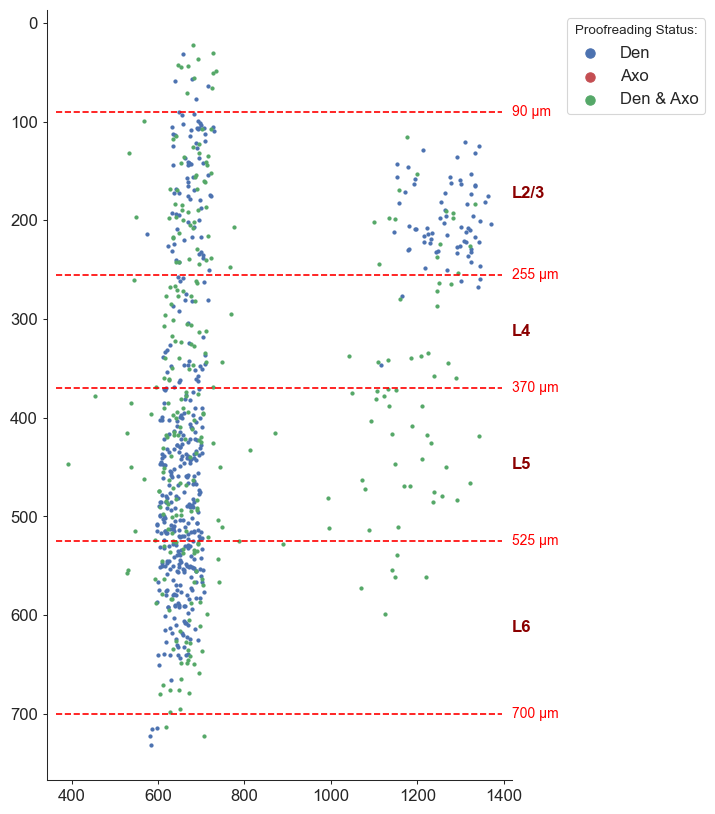

In [75]:
den_proof = proofreading_table.status_dendrite.isin(["clean", "extended"])
axo_proof = proofreading_table.status_axon.isin(["extended"])

fig, ax = plt.subplots(figsize=(6, 10))
pos = nm_transform.apply(np.vstack(proofreading_table.pt_position.values))
ax.scatter(pos[den_proof & ~axo_proof, 0], pos[den_proof & ~axo_proof, 1], s=5, color="b", label="Den")
ax.scatter(pos[~den_proof & axo_proof, 0], pos[~den_proof & axo_proof, 1], s=5, color="r", label="Axo")
ax.scatter(pos[den_proof & axo_proof, 0], pos[den_proof & axo_proof, 1], s=5, color="g", label="Den & Axo")
ax.invert_yaxis()
ax.legend(loc="upper left", bbox_to_anchor=(1.1,1), bbox_transform=ax.transAxes, title="Proofreading Status:", markerscale=3)
add_layer_lines(ax)

In [80]:
axo_proof_pt_root_ids = proofreading_table.pt_root_id.values[axo_proof]
den_proof_pt_root_ids = proofreading_table.pt_root_id.values[den_proof]
proof_pt_root_ids = proofreading_table.pt_root_id.values[den_proof & axo_proof]
len(proof_pt_root_ids)

289

# Look at cell types

In [53]:
soma_df = client.materialize.query_table("aibs_soma_nuc_metamodel_preds_v117")
soma_df["pt_position_microns"] = nm_transform.apply(soma_df["pt_position"])
soma_df

,id,valid,target_id,classification_system,cell_type,id_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,pt_position_microns
0,553,t,498173,aibs_neuronal,6P-IT,498173,t,308.176159,103884538719281829,864691136091295156,"[1138752.0, 847744.0, 622640.0]","[nan, nan, nan]","[nan, nan, nan]","[1060.532946861501, 547.0958222941854, 622.640..."
1,4509,t,487329,aibs_neuronal,MC,487329,t,295.937638,105279407463397326,864691135975935434,"[1178176.0, 474496.0, 869800.0]","[nan, nan, nan]","[nan, nan, nan]","[1132.3376333081478, 178.7041716229213, 869.80..."
2,4693,t,106662,aibs_neuronal,23P,106662,t,230.148178,79524515478544304,864691136084076652,"[428224.0, 476992.0, 776560.0]","[nan, nan, nan]","[nan, nan, nan]","[385.0218863509487, 115.82805000426656, 776.56..."
3,5061,t,271350,aibs_neuronal,6P-CT,271350,t,305.328128,87351114324194368,864691135937342005,"[655680.0, 943872.0, 835000.0]","[nan, nan, nan]","[nan, nan, nan]","[570.9210744260782, 600.755527271752, 835.0000..."
4,8652,t,456040,aibs_neuronal,MC,456040,t,257.463910,101129507251445952,864691136084057196,"[1058176.0, 530112.0, 959520.0]","[nan, nan, nan]","[nan, nan, nan]","[1007.9470157484845, 223.64984682227282, 959.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86911,86912,t,390522,aibs_neuronal,23P,390522,t,287.910625,97749195318464441,864691136116477604,"[959680.0, 451456.0, 693920.0]","[nan, nan, nan]","[nan, nan, nan]","[916.6811448667997, 136.70866461149515, 693.92..."
86912,86913,t,329229,aibs_neuronal,4P,329229,t,271.882322,92547130727975969,864691135740183915,"[808704.0, 607040.0, 626400.0]","[nan, nan, nan]","[nan, nan, nan]","[752.7196150480487, 278.54219510233094, 626.40..."
86913,86914,t,589184,aibs_nonneuronal,oligo,589184,t,124.472852,110987178548578816,864691135081676023,"[1343680.0, 710784.0, 885360.0]","[nan, nan, nan]","[nan, nan, nan]","[1276.6179844787655, 428.51764849333216, 885.3..."
86914,86915,t,256280,aibs_neuronal,23P,256280,t,354.738012,87546415009833381,864691136966016974,"[663232.0, 473024.0, 807920.0]","[nan, nan, nan]","[nan, nan, nan]","[619.4814439473164, 132.35744623388018, 807.92..."


In [54]:
EXCITATORY_NEURON_CELL_TYPE = ["23P", "4P", "5P-ET", "5P-IT", "5P-NP", "6P-IT", "6P-CT"]
INHIBITORY_NEURON_CELL_TYPE = ["BC", "BPC", "MC", "NGC"]

In [55]:
soma_df.cell_type.value_counts()

23P          19139
4P           13407
6P-IT        10746
5P-IT         9060
astrocyte     7724
6P-CT         5862
oligo         4998
BC            3084
microglia     3024
OPC           2483
MC            2270
5P-ET         1626
BPC           1424
pericyte       962
NGC            651
5P-NP          456
Name: cell_type, dtype: int64

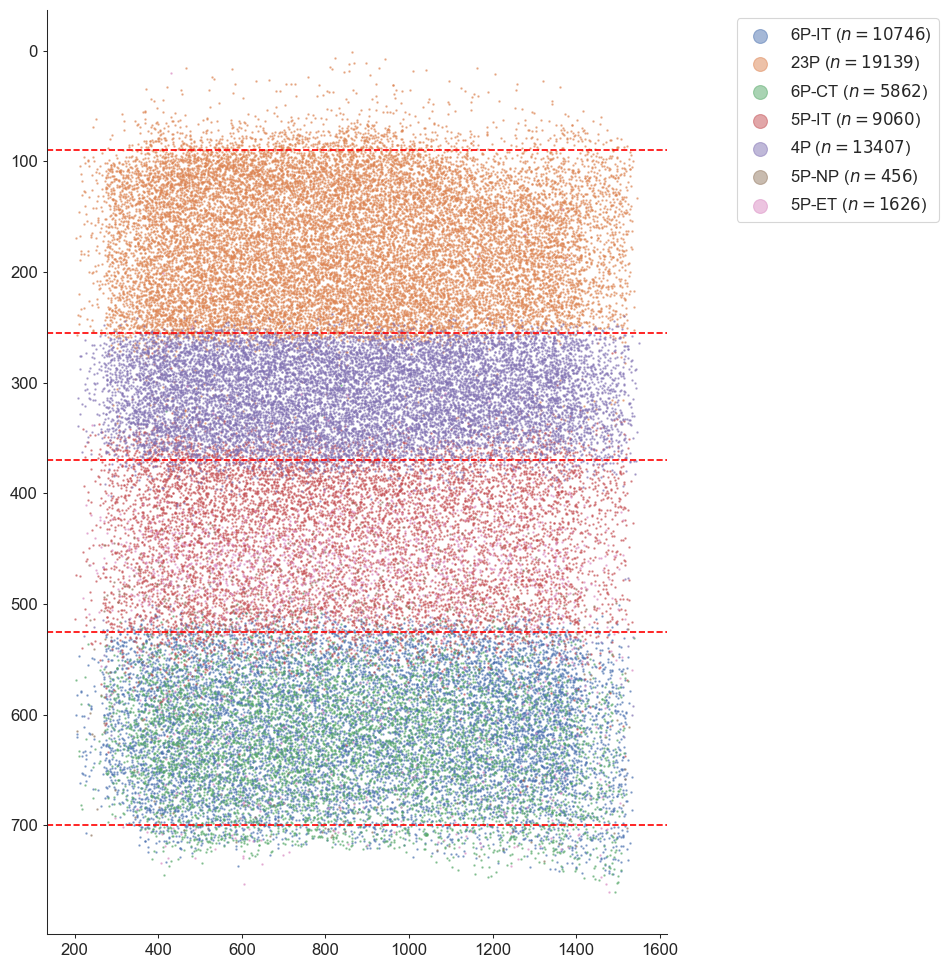

In [70]:
fig, ax = plt.subplots(figsize=(8, 12))

for cell_type in soma_df.cell_type.unique():
    if cell_type not in EXCITATORY_NEURON_CELL_TYPE: continue
    pos = soma_df.pt_position_microns[soma_df.cell_type == cell_type]
    x = pos.apply(itemgetter(0))
    y = pos.apply(itemgetter(1))
    ax.scatter(x, y, label=f"{cell_type} ($n = {len(pos)}$)", s=1, alpha=0.5)

ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1), bbox_transform=ax.transAxes, markerscale=10)
ax.invert_yaxis()
# add_layer_lines(ax)

for y in (90, 255, 370, 525, 700):
    ax.axhline(y, color="red", linestyle="dashed")

In [57]:
coreg_root_ids = client.materialize.query_table("functional_coreg").pt_root_id.values

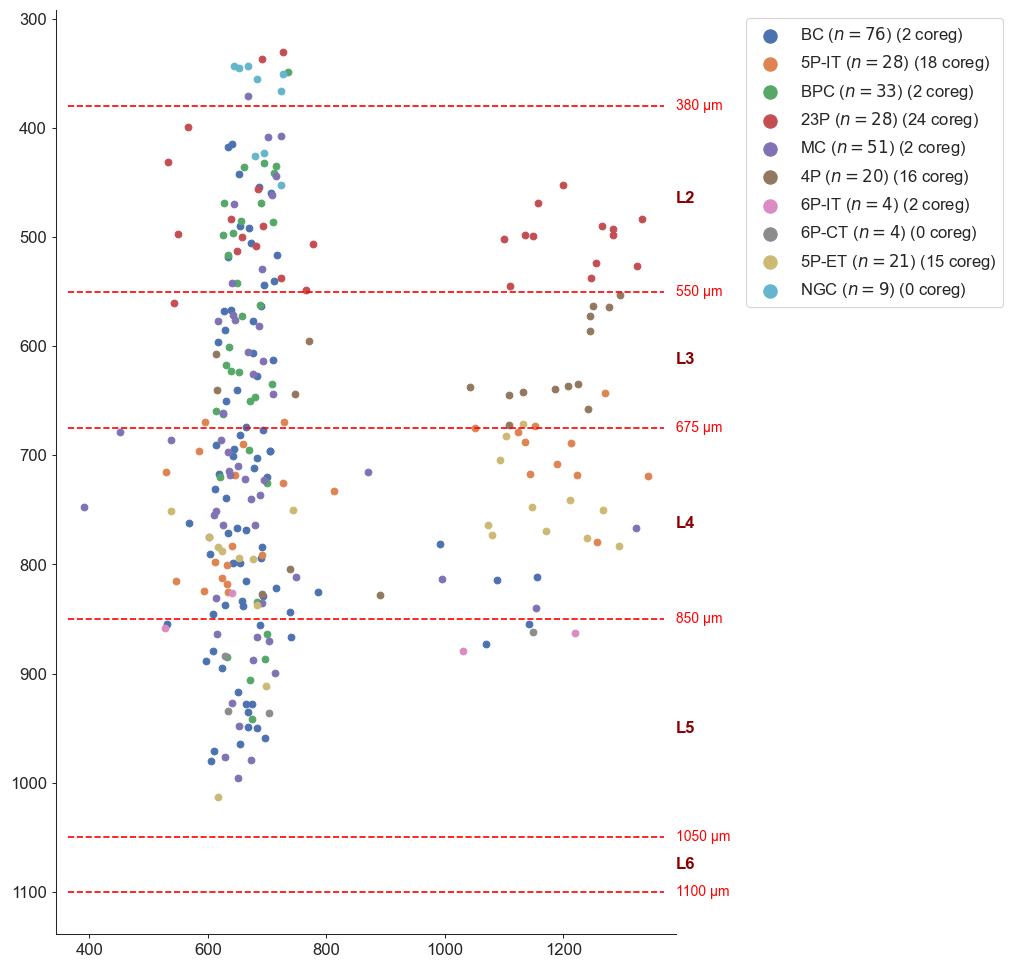

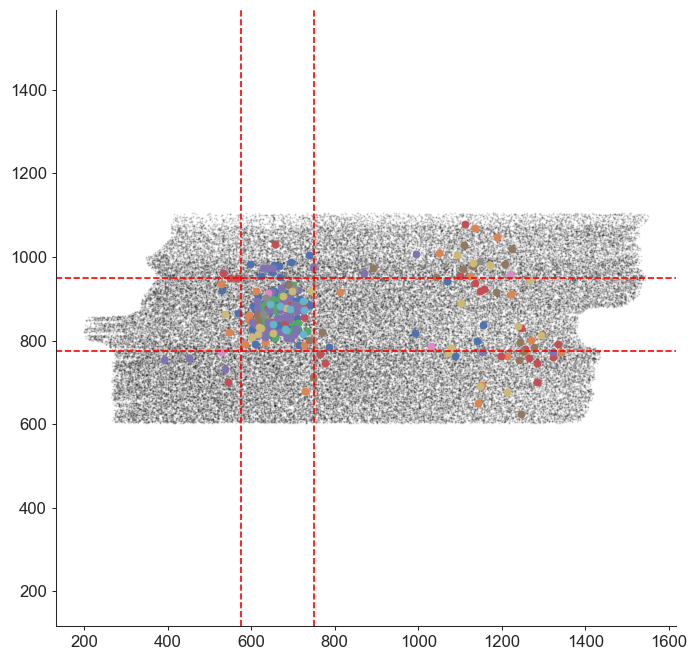

In [92]:
proof_soma_df = soma_df[soma_df.pt_root_id.isin(axo_proof_pt_root_ids)]
fig, ax = plt.subplots(figsize=(8, 12))

for cell_type in proof_soma_df.cell_type.unique():
    mask = proof_soma_df.cell_type == cell_type
    pos = proof_soma_df.pt_position_microns[mask]
    x = pos.apply(itemgetter(0))
    y = pos.apply(itemgetter(1))
    ax.scatter(x, y, label=f"{cell_type} ($n = {len(pos)}$) ({proof_soma_df.pt_root_id[mask].isin(coreg_root_ids).sum()} coreg)")

ax.legend(loc="upper left", bbox_to_anchor=(1.1,1), bbox_transform=ax.transAxes, markerscale=2)
ax.invert_yaxis()
add_layer_lines(ax)


# Top view
fig, ax = plt.subplots(figsize=(8, 8))
pos_all = soma_df.pt_position_microns
ax.scatter(pos_all.apply(itemgetter(0)), pos_all.apply(itemgetter(2)), color="black", s=0.5, alpha=0.1)
for cell_type in proof_soma_df.cell_type.unique():
    pos = proof_soma_df.pt_position_microns[proof_soma_df.cell_type == cell_type]
    ax.scatter(pos.apply(itemgetter(0)), pos.apply(itemgetter(2)), label=cell_type)
ax.axis("equal")
ax.axvline(575, color="red", linestyle="dashed")
ax.axvline(750, color="red", linestyle="dashed")
ax.axhline(775, color="red", linestyle="dashed")
ax.axhline(950, color="red", linestyle="dashed")

In [83]:
def is_in_central_column(pos):
    return 575 <= pos[0] <= 750 and 775 <= pos[2] <= 950

In [18]:
mc_root_ids = proof_soma_df[proof_soma_df.pt_position_microns.apply(lambda pos: pos[1]) < 650]

proof_soma_df[proof_soma_df.pt_position_microns.apply(lambda pos: pos[1]) < 650].cell_type.value_counts()

23P      28
BC       22
BPC      21
MC       16
4P       15
NGC       9
5P-IT     1
Name: cell_type, dtype: int64

In [19]:
mc_root_id = 864691135373819592	

In [20]:
from nglui.statebuilder.helpers import make_neuron_neuroglancer_link

In [21]:
make_neuron_neuroglancer_link(client, mc_root_id, return_as="url")

'https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/5435217959452672'

In [22]:
soma_df = soma_df.drop_duplicates("pt_root_id", keep=False)

In [23]:
axo_syn = client.materialize.synapse_query(pre_ids=mc_root_id)
den_syn = client.materialize.synapse_query(post_ids=mc_root_id)
axo_syn

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,186261921,t,91486790208300622,864691135373819592,91486790208309493,864691134940175459,260,"[778232.0, 465264.0, 923480.0]","[778032.0, 465376.0, 923920.0]","[778216.0, 465096.0, 923680.0]"
1,172466485,t,90291002593589285,864691135373819592,90291002593582912,864691135677812772,2396,"[742800.0, 479992.0, 923360.0]","[743048.0, 479984.0, 922960.0]","[742868.0, 479864.0, 923080.0]"
2,157386506,t,88880672839688863,864691135373819592,88880672839700198,864691135526062171,5624,"[702264.0, 390560.0, 945240.0]","[702040.0, 390424.0, 945560.0]","[702328.0, 390632.0, 945360.0]"
3,177585893,t,90924046279209954,864691135373819592,90924046279204785,864691136099892853,1452,"[760392.0, 471824.0, 887840.0]","[760624.0, 471744.0, 887840.0]","[760408.0, 471880.0, 887840.0]"
4,178298305,t,90853334072239790,864691135373819592,90853402791739439,864691136617339355,716,"[758096.0, 461456.0, 941080.0]","[758000.0, 461864.0, 941080.0]","[758064.0, 461696.0, 941160.0]"
...,...,...,...,...,...,...,...,...,...,...
5257,164753676,t,89659470468502634,864691135373819592,89659470468502822,864691135256191407,3044,"[723224.0, 532912.0, 894400.0]","[723464.0, 533232.0, 894720.0]","[723200.0, 532960.0, 894400.0]"
5258,136810821,t,87473297888959914,864691135373819592,87473297888950885,864691136194419276,1212,"[660040.0, 391088.0, 922520.0]","[660456.0, 391184.0, 922200.0]","[660320.0, 391212.0, 922200.0]"
5259,165130277,t,89727708975772946,864691135373819592,89727708975767214,864691135658120834,3340,"[726136.0, 469192.0, 905880.0]","[726240.0, 469024.0, 905640.0]","[726160.0, 469232.0, 905760.0]"
5260,152956152,t,88814908166293827,864691135373819592,88814908166308252,864691135445555090,372,"[700200.0, 528592.0, 905360.0]","[700384.0, 528608.0, 905880.0]","[700080.0, 528480.0, 905640.0]"


In [24]:
print("% PREsyn cells in volume:", den_syn.pre_pt_root_id.isin(nucleus_detection.pt_root_id).mean()*100)
print("% POSTsyn cells in volume:", axo_syn.post_pt_root_id.isin(nucleus_detection.pt_root_id).mean()*100)
print()
print("% PREsyn cells with type:", den_syn.pre_pt_root_id.isin(soma_df.pt_root_id).mean()*100)
print("% POSTsyn cells with type:", axo_syn.post_pt_root_id.isin(soma_df.pt_root_id).mean()*100)

% PREsyn cells in volume: 7.650907555930772
% POSTsyn cells in volume: 89.64795432921028

% PREsyn cells with type: 6.869987336428873
% POSTsyn cells with type: 77.37392959086584


In [25]:
pre_root_ids = den_syn.pre_pt_root_id
post_root_ids = axo_syn.post_pt_root_id

In [86]:
root_id_to_cell_type = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.cell_type.values)
root_id_to_soma_pos = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.pt_position_microns.values)

In [27]:
# f_pct = lambda n_total: lambda x: f"{x} / {n_total} ({x/n_total*100:.2f}%)"
f_pct = lambda n_total: lambda x: f"{x} ({x/n_total*100:.2f}%)"

print(f"  PRE cell types (n = {len(pre_root_ids)}):")
print(pre_root_ids.apply(lambda id: root_id_to_cell_type.get(id, None)).value_counts(dropna=False).apply(f_pct(len(pre_root_ids))))

print()
print(f"  POST cell types (n = {len(post_root_ids)}):")
print(post_root_ids.apply(lambda id: root_id_to_cell_type.get(id, None)).value_counts(dropna=False).apply(f_pct(len(post_root_ids))))

  PRE cell types (n = 9476):
None         8825 (93.13%)
23P            301 (3.18%)
BPC            108 (1.14%)
BC             104 (1.10%)
MC              60 (0.63%)
microglia       20 (0.21%)
4P              17 (0.18%)
astrocyte       12 (0.13%)
5P-IT           10 (0.11%)
OPC              7 (0.07%)
oligo            6 (0.06%)
NGC              5 (0.05%)
6P-IT            1 (0.01%)
Name: pre_pt_root_id, dtype: object

  POST cell types (n = 5255):
23P          3542 (67.40%)
None         1189 (22.63%)
BC             123 (2.34%)
BPC            122 (2.32%)
4P              72 (1.37%)
5P-ET           65 (1.24%)
MC              43 (0.82%)
5P-IT           39 (0.74%)
NGC             27 (0.51%)
6P-IT           14 (0.27%)
5P-NP           13 (0.25%)
astrocyte        6 (0.11%)
Name: post_pt_root_id, dtype: object


Text(0, 0.5, 'Fraction of presynaptic cells within distance')

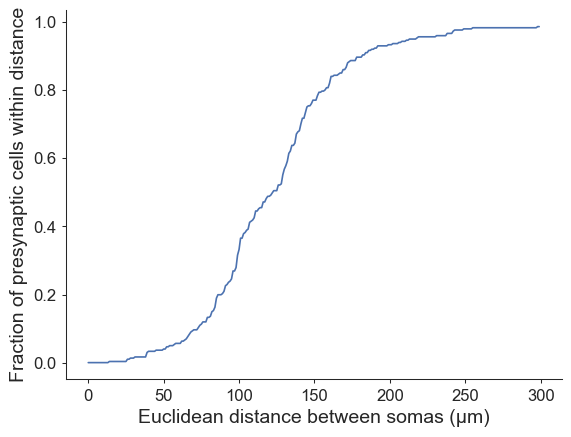

In [28]:
# Plot connectivity proba to L2/3 PCs
pre_23pc_root_ids = pre_root_ids[pre_root_ids.apply(lambda id: root_id_to_cell_type.get(id) == "23P")].values
pre_soma_pos = [root_id_to_soma_pos[id] for id in pre_23pc_root_ids]
this_mc_soma_pos = np.array(root_id_to_soma_pos[mc_root_id])
soma_distances = np.array([np.linalg.norm(x - this_mc_soma_pos) for x in pre_soma_pos])
dist_range = np.arange(0, 300)
frac_within_dist = [np.mean(soma_distances < d) for d in dist_range]
plt.plot(dist_range, frac_within_dist)
plt.xlabel("Euclidean distance between somas (µm)")
plt.ylabel("Fraction of presynaptic cells within distance")

Text(0, 0.5, 'Fraction of postsynaptic cells within distance')

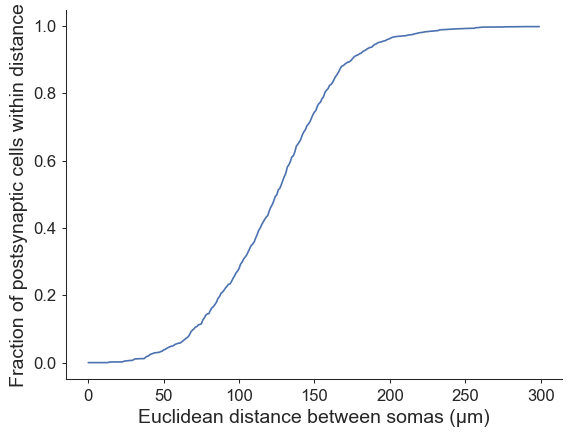

In [29]:
# Plot connectivity proba to L2/3 PCs
post_23pc_root_ids = post_root_ids[post_root_ids.apply(lambda id: root_id_to_cell_type.get(id) == "23P")].values
post_soma_pos = [root_id_to_soma_pos[id] for id in post_23pc_root_ids]
this_mc_soma_pos = np.array(root_id_to_soma_pos[mc_root_id])
soma_distances = np.array([np.linalg.norm(x - this_mc_soma_pos) for x in post_soma_pos])
dist_range = np.arange(0, 300)
frac_within_dist = [np.mean(soma_distances < d) for d in dist_range]
plt.plot(dist_range, frac_within_dist)
plt.xlabel("Euclidean distance between somas (µm)")
plt.ylabel("Fraction of postsynaptic cells within distance")

# Estimate connection probabilities based on all somas

In [77]:
def matches_or_in(series, val):
    if type(val) is str:
        return series == val
    else:
        return series.isin(val)

def get_cell_type_str(cell_type):
    if cell_type == EXCITATORY_NEURON_CELL_TYPE:
        return "exc"
    elif cell_type == INHIBITORY_NEURON_CELL_TYPE:
        return "inh"
    elif type(cell_type) is not str:
        return str(cell_type)
    else:
        return cell_type

cmap = mpl.colormaps.get_cmap("jet_r") # red for shallower, blue for deeper
fig_dir = "/Users/chase/Desktop/conn_probas"
os.makedirs(fig_dir, exist_ok=True)

plotting_configs = []
plotting_layers = ["2", "3", "23", "4", "5", "6"]
plotting_inhib_types = ["MC", "BC", "BPC"]

for i, layer in enumerate(plotting_layers):
    plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, layer, EXCITATORY_NEURON_CELL_TYPE, layer))

    for inhib in plotting_inhib_types:
        plotting_configs.append((inhib, layer, EXCITATORY_NEURON_CELL_TYPE, layer))
        plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, layer, inhib, layer))
        plotting_configs.append((inhib, layer, inhib, layer))

        for inhib2 in plotting_inhib_types:
            if inhib2 != inhib:
                plotting_configs.append((inhib, layer, inhib2, layer))

        if i < len(plotting_layers) - 1:
            next_layer = plotting_layers[i+1]
            plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, layer, EXCITATORY_NEURON_CELL_TYPE, next_layer))
            plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, next_layer, EXCITATORY_NEURON_CELL_TYPE, layer))
            plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, layer, INHIBITORY_NEURON_CELL_TYPE, next_layer))
            plotting_configs.append((EXCITATORY_NEURON_CELL_TYPE, next_layer, INHIBITORY_NEURON_CELL_TYPE, layer))

len(plotting_configs)

156

In [144]:
for pre_cell_type, pre_layer, post_cell_type, post_layer in tqdm(plotting_configs, desc="Connection probability plots"):
    pre_population_soma_df_mask = matches_or_in(soma_df.cell_type, pre_cell_type) \
                                    & is_in_layer(soma_df.pt_position_microns, pre_layer) \
                                    & soma_df.pt_root_id.isin(axo_proof_pt_root_ids) \
                                    & soma_df.pt_position_microns.apply(is_in_central_column)
    post_population_soma_df_mask = matches_or_in(soma_df.cell_type, post_cell_type) \
                                    & is_in_layer(soma_df.pt_position_microns, post_layer)

    pre_root_ids = soma_df.pt_root_id.values[pre_population_soma_df_mask]
    post_population_root_ids = soma_df.pt_root_id.values[post_population_soma_df_mask]
    post_population_soma_pos = np.vstack(soma_df.pt_position_microns.values[post_population_soma_df_mask])
    pre_soma_y = soma_df.pt_position_microns[pre_population_soma_df_mask].apply(lambda pos: pos[1])
    cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())


    all_axo_syn = client.materialize.synapse_query(pre_ids=pre_root_ids)

    dist_range = np.arange(20, 401)
    dist_window_radius = 20 # Fudging this doesn't seem to affect probability curve

    fig, ax = plt.subplots(figsize=(10, 5))

    ax_inset = ax.inset_axes([0.65, 0.5, 0.3, 0.4])
    ax_inset.scatter(post_population_soma_pos[:,0], post_population_soma_pos[:,1], color="black", s=0.1, alpha=0.25, label=f"{post_cell_type}")
    ax_inset.invert_yaxis()

    for this_root_id in pre_root_ids:
        axo_syn = all_axo_syn[all_axo_syn.pre_pt_root_id == this_root_id]
        this_soma_pos = np.array(root_id_to_soma_pos[this_root_id])
        post_population_soma_dist = np.linalg.norm(post_population_soma_pos - this_soma_pos, axis=1)
        post_root_ids = axo_syn.post_pt_root_id.values

        conn_proba = np.zeros_like(dist_range, dtype=float)
        y_err = np.zeros_like(dist_range, dtype=float)

        for i, d in enumerate(dist_range):
            # root_ids_within_dist = post_population_root_ids[post_population_soma_dist <= d]
            root_ids_within_dist = post_population_root_ids[np.abs(post_population_soma_dist - d) <= dist_window_radius]
            are_none = len(root_ids_within_dist) == 0
            conn_proba[i] = np.nan if are_none else np.mean(np.isin(root_ids_within_dist, post_root_ids))
            y_err[i] = np.nan if are_none else 1/np.sqrt(len(root_ids_within_dist))

        # color = ax.scatter(dist_range, conn_proba, alpha=0.8).get_facecolor()
        # color = ax.plot(dist_range, conn_proba, linewidth=2)[0].get_color()
        color = cmap(cmap_norm(this_soma_pos[1]))
        ax.plot(dist_range, conn_proba, color=color, linewidth=2)
        if len(pre_root_ids) <= 10:
            ax.fill_between(dist_range, conn_proba-y_err, conn_proba+y_err, color=color, alpha=0.1)
        ax_inset.scatter(this_soma_pos[0], this_soma_pos[1], color=color)


    # Update axes
    ax.set_xlabel("Euclidean distance between somas (µm)")
    ax.set_ylabel("Connection probability at distance")
    pre_type_str = get_cell_type_str(pre_cell_type)
    post_type_str = get_cell_type_str(post_cell_type)
    ax.set_title(f"P(L{pre_layer} {pre_type_str} $\\longrightarrow$ L{post_layer} {post_type_str}), $n = {len(pre_root_ids)}$", fontsize=16)
    ax.set_xlim(0, dist_range.max())
    ax.set_ylim(0, 1)

    (xmin, xmax), (ymin, ymax) = ax_inset.get_xlim(), ax_inset.get_ylim()
    ax_inset.vlines(x=xmin, ymin=ymin, ymax=ymin-100, color="black")
    ax_inset.hlines(y=ymin, xmin=xmin, xmax=xmin+100, color="black")
    ax_inset.text(0, 0, "100 µm", transform=ax_inset.transAxes, fontsize=10, va="top", ha="left")
    ax_inset.text(1, 0.5, "Postsynaptic\npopulation", fontsize=10, transform=ax_inset.transAxes, va="center", ha="left")
    ax_inset.axis("off")

    fig.tight_layout()
    file_name = f"L{pre_layer.replace('/', '')}_{pre_type_str}_to_L{post_layer.replace('/', '')}_{post_type_str}"
    fig.savefig(f"{fig_dir}/{file_name}.png", dpi=200)
    plt.close(fig)

Connection probability plots: 100%|██████████| 156/156 [14:39<00:00,  5.64s/it]


# Soma to axonal synapse estimates

In [189]:
pre_cell_type = "MC"
pre_layer = "2/3"
post_cell_type = "BC"
post_layer = "2/3"

pre_population_soma_df_mask = matches_or_in(soma_df.cell_type, pre_cell_type) \
                                & is_in_layer(soma_df.pt_position_microns, pre_layer) \
                                & soma_df.pt_root_id.isin(axo_proof_pt_root_ids) \
                                & soma_df.pt_position_microns.apply(is_in_central_column)
post_population_soma_df_mask = matches_or_in(soma_df.cell_type, post_cell_type) \
                                & is_in_layer(soma_df.pt_position_microns, post_layer)
                                # & soma_df.pt_root_id.isin(den_proof_pt_root_ids) \

print(f"n pre = {pre_population_soma_df_mask.sum()}, n post = {post_population_soma_df_mask.sum()}")

pre_root_ids = soma_df.pt_root_id.values[pre_population_soma_df_mask]
post_population_root_ids = soma_df.pt_root_id.values[post_population_soma_df_mask]
post_population_soma_pos = np.vstack(soma_df.pt_position_microns.values[post_population_soma_df_mask])
pre_soma_y = soma_df.pt_position_microns[pre_population_soma_df_mask].apply(lambda pos: pos[1])
cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())

all_axo_syn = client.materialize.synapse_query(pre_ids=pre_root_ids)

n pre = 11, n post = 712


In [190]:
all_axo_syn["syn_pos_microns"] = list(nm_transform.column_apply(all_axo_syn["ctr_pt_position"], return_array=True))
all_axo_syn["soma_to_syn_dist_microns"] = all_axo_syn.apply(lambda row: np.linalg.norm(row["syn_pos_microns"] - root_id_to_soma_pos[row["pre_pt_root_id"]]), axis=1)
all_axo_syn.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,syn_pos_microns,soma_to_syn_dist_microns
0,186261921,t,91486790208300622,864691135373819592,91486790208309493,864691134940175459,260,"[778232.0, 465264.0, 923480.0]","[778032.0, 465376.0, 923920.0]","[778216.0, 465096.0, 923680.0]","[734.7188658412011, 134.4811305915055, 923.680...",105.807148
1,130415403,t,87195258349484276,864691135502367669,87195258349478600,864691135366986745,3204,"[651992.0, 493976.0, 768080.0]","[651584.0, 493984.0, 767880.0]","[651760.0, 493792.0, 768000.0]","[606.2430479054245, 152.04656704304838, 768.00...",135.050719
2,184404678,t,91273141422403887,864691136143786292,91273141422404977,864691136175448326,3400,"[771168.0, 389128.0, 950720.0]","[771336.0, 389552.0, 950880.0]","[771304.0, 389304.0, 951000.0]","[734.4388761423214, 58.37512153986417, 951.000...",146.092914
3,165748417,t,89936203667196240,864691135800027234,89936203667202109,864691136973936156,540,"[733016.0, 390496.0, 857240.0]","[733112.0, 390424.0, 857640.0]","[733060.0, 390304.0, 857560.0]","[696.253250365753, 56.0381320123144, 857.56000...",59.785293
4,164435719,t,89656446609936734,864691135754910674,89656446609926481,864691136423028271,8208,"[724416.0, 441520.0, 822880.0]","[724832.0, 441496.0, 822680.0]","[724672.0, 441784.0, 822680.0]","[683.4103916015101, 106.59117269991013, 822.68...",75.016226


(96.1861254160941, 1584.5977770788847, 301.64925418337117, 54.519070901600784)

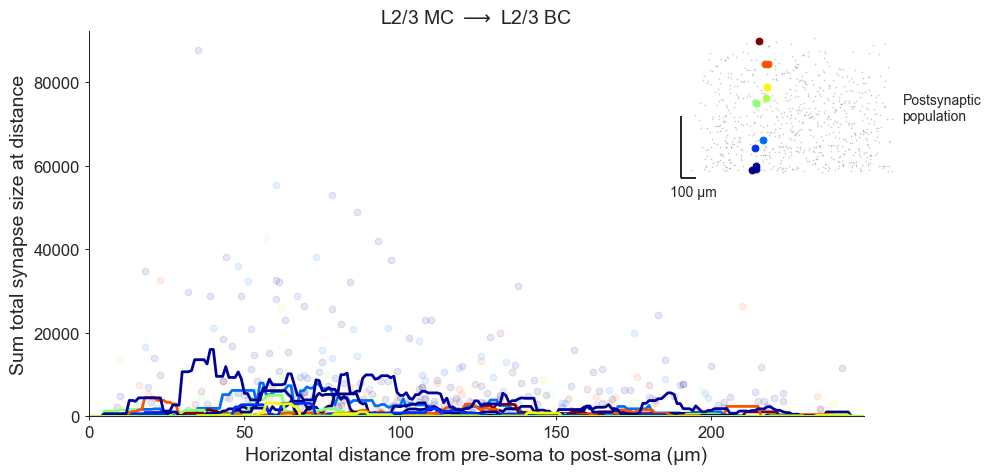

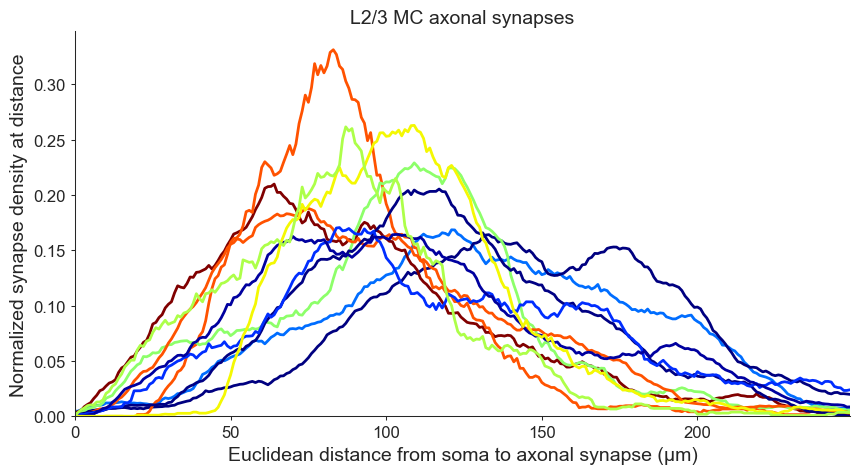

In [191]:
dist_range = np.arange(0, 250)
dist_window_radius_axon = 10 # Fudging this doesn't seem to affect probability curve
dist_window_radius = 0.5
cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"L{pre_layer} {get_cell_type_str(pre_cell_type)} $\\longrightarrow$ L{post_layer} {get_cell_type_str(post_cell_type)}")
ax.set_xlabel("Horizontal distance from pre-soma to post-soma (µm)")
ax.set_ylabel("Sum total synapse size at distance")
ax_inset = ax.inset_axes([0.75, 0.6, 0.3, 0.4])

fig, ax_axon = plt.subplots(figsize=(10, 5))
ax_axon.set_title(f"L{pre_layer} {get_cell_type_str(pre_cell_type)} axonal synapses")
ax_axon.set_xlabel("Euclidean distance from soma to axonal synapse (µm)")
ax_axon.set_ylabel("Normalized synapse density at distance")

for this_root_id in all_axo_syn.pre_pt_root_id.unique():
    this_soma_pos = root_id_to_soma_pos[this_root_id]

    syn = all_axo_syn[all_axo_syn.pre_pt_root_id == this_root_id]
    post_population_soma_dist = np.linalg.norm((post_population_soma_pos - this_soma_pos)[:, ::2], axis=1) # ::2 = ignore middle (y) dimension
    syn_weight_at_axon_dist = np.zeros_like(dist_range, dtype=float)
    syn_weight_at_dist = np.zeros_like(dist_range, dtype=float)

    for i, d in enumerate(dist_range):
        syn_within_dist = syn[np.abs(syn.soma_to_syn_dist_microns - d) <= dist_window_radius_axon]
        syn_weight_at_axon_dist[i] = np.nan if len(syn_within_dist) == 0 else syn_within_dist["size"].sum()

        # Compute soma-soma synapse density
        post_root_ids_within_dist = post_population_root_ids[np.abs(post_population_soma_dist - d) <= dist_window_radius]
        syn_within_dist = syn[syn.post_pt_root_id.isin(post_root_ids_within_dist)]
        syn_weight_at_dist[i] = np.nan if len(syn_within_dist) == 0 else syn_within_dist["size"].sum()
    
    total_syn_size = syn["size"].sum()
    syn_density_at_axon_dist = syn_weight_at_axon_dist / total_syn_size
    syn_density_at_dist = syn_weight_at_dist / total_syn_size
    # syn_weight_at_dist = syn_weight_at_dist / total_syn_size
        
    color = cmap(cmap_norm(this_soma_pos[1]))
    ax_axon.plot(dist_range, syn_density_at_axon_dist, color=color, linewidth=2)
    # ax.plot(dist_range, syn_density_at_dist, color=color, linewidth=2)
    # ax.plot(dist_range, syn_weight_at_dist, color=color, linewidth=2)

    ax.scatter(dist_range, syn_weight_at_dist, color=color, alpha=0.1)
    rolling_avg_r = 5
    y_rolling_avg = np.zeros_like(dist_range, dtype=float)
    # kernel = np.array([0]*rolling_avg_r + [1] + [0]*rolling_avg_r, dtype=float)
    kernel = np.ones(2*rolling_avg_r+1) / (2*rolling_avg_r+1) # Rolling average kernel
    # kernel = scipy.ndimage.gaussian_filter1d(kernel, sigma=3) # Gaussian kernel
    for i in range(rolling_avg_r, len(dist_range) - rolling_avg_r):
        y_rolling_avg[i] = np.nansum(syn_weight_at_dist[i-rolling_avg_r:i+rolling_avg_r+1] * kernel)
    ax.plot(dist_range, y_rolling_avg, color=color, linewidth=2)

    ax_inset.scatter(this_soma_pos[0], this_soma_pos[1], color=color)

ax_axon.set_xlim(dist_range.min(), dist_range.max())
ax_axon.set_ylim(0, ax_axon.get_ylim()[1])

ax.set_xlim(dist_range.min(), dist_range.max())
ax.set_ylim(0, ax.get_ylim()[1])

ax_inset.scatter(post_population_soma_pos[:,0], post_population_soma_pos[:,1], color="black", s=0.1, alpha=0.25, zorder=0, label=f"{post_cell_type}")
ax_inset.invert_yaxis()
(xmin, xmax), (ymin, ymax) = ax_inset.get_xlim(), ax_inset.get_ylim()
ax_inset.vlines(x=xmin, ymin=ymin, ymax=ymin-100, color="black")
ax_inset.hlines(y=ymin, xmin=xmin, xmax=xmin+100, color="black")
ax_inset.text(0, 0, "100 µm", transform=ax_inset.transAxes, fontsize=10, va="top", ha="left")
ax_inset.text(1, 0.5, "Postsynaptic\npopulation", fontsize=10, transform=ax_inset.transAxes, va="center", ha="left")
ax_inset.axis("off")

(-22.15022392079353, 699.1092602756346, -16.9913766797519, 551.0977202361422)

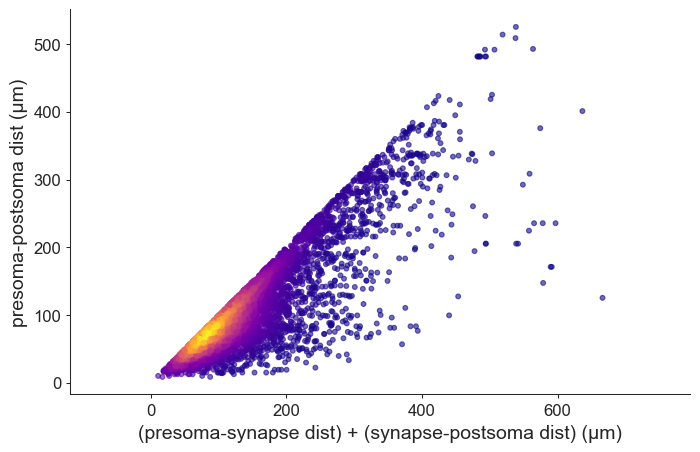

In [104]:
dist_range = np.arange(0, 401)
dist_window_radius = 10 # Fudging this doesn't seem to affect probability curve
cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlabel("(presoma-synapse dist) + (synapse-postsoma dist) (µm)")
ax.set_ylabel("presoma-postsoma dist (µm)")
x, y, c = [], [], []

for this_root_id in all_axo_syn.pre_pt_root_id.unique():
    this_soma_pos = np.array(root_id_to_soma_pos[this_root_id])

    syn = all_axo_syn[(all_axo_syn.pre_pt_root_id == this_root_id) & all_axo_syn.post_pt_root_id.isin(root_id_to_soma_pos.index) & all_axo_syn.post_pt_root_id.isin(den_proof_pt_root_ids)]
    color = cmap(cmap_norm(this_soma_pos[1]))
    
    for _, row in syn.iterrows():
        post_soma_pos = np.array(root_id_to_soma_pos[row["post_pt_root_id"]])
        x.append(row["soma_to_syn_dist_microns"] + np.linalg.norm(row["syn_pos_microns"] - post_soma_pos))
        y.append(np.linalg.norm(this_soma_pos - post_soma_pos))
        c.append(color)

# ax.scatter(x, y, c=c, alpha=0.5)
at.density_scatter(x, y, ax=ax)
ax.axis("equal")

# Plot MC inputs to L2/3 PYCs

In [118]:
all_post_root_ids = soma_df[
    soma_df.pt_position_microns.apply(lambda pos: is_in_central_column(pos) and is_in_layer(pos, "23", boundary_padding=0))
    # & soma_df.cell_type.isin(EXCITATORY_NEURON_CELL_TYPE)
    & (soma_df.cell_type == "23P")
].pt_root_id.values
print(f"n post = {len(all_post_root_ids)}")

n post = 1106


In [122]:
all_pre_root_ids = soma_df[
    soma_df.pt_position_microns.apply(lambda pos: is_in_central_column(pos))
    & (soma_df.cell_type == "MC")
    & (soma_df.pt_root_id.isin(axo_proof_pt_root_ids))
].pt_root_id.values

print(f"n pre = {len(all_pre_root_ids)}")

n pre = 40


In [123]:
n = 5
pre_root_ids = np.random.choice(all_pre_root_ids, size=n, replace=False)

# Load the axonal synapses
all_axo_syn = client.materialize.synapse_query(pre_ids=pre_root_ids)
all_axo_syn

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,169136758,t,89807698312872195,864691135194776874,89878067057034089,864691135809723852,2804,"[729024.0, 755496.0, 879240.0]","[729528.0, 755544.0, 879240.0]","[729104.0, 755600.0, 879240.0]"
1,176768505,t,90233827586488815,864691135194776874,90233827586484778,864691135571383333,1960,"[739976.0, 871808.0, 807240.0]","[740488.0, 871952.0, 807080.0]","[740184.0, 871864.0, 807120.0]"
2,154005748,t,88752716905529483,864691135194776874,88752716905528257,864691135991789505,944,"[697584.0, 771488.0, 861280.0]","[697288.0, 771816.0, 861360.0]","[697480.0, 771504.0, 861520.0]"
3,183497188,t,91007402601730980,864691135194776874,91007402601729706,864691136023743033,204,"[762408.0, 856904.0, 760800.0]","[762512.0, 856896.0, 760960.0]","[762408.0, 856992.0, 760880.0]"
4,175553346,t,90369961742396844,864691135194776874,90369961742387871,864691136709406062,5836,"[744608.0, 734088.0, 1076520.0]","[744768.0, 734408.0, 1076480.0]","[744712.0, 734144.0, 1076560.0]"
...,...,...,...,...,...,...,...,...,...,...
28600,154121151,t,88467806022350675,864691136903457202,88467806022341735,864691135490421095,3920,"[688664.0, 668736.0, 891760.0]","[688944.0, 668984.0, 891680.0]","[688656.0, 668848.0, 891680.0]"
28601,186699660,t,91353542941791111,864691136903457202,91353542941794947,864691136973809436,9336,"[774104.0, 687888.0, 871000.0]","[773912.0, 687568.0, 871080.0]","[774132.0, 687672.0, 870840.0]"
28602,159478197,t,88959905792368288,864691136903457202,88959905792371063,864691136005035466,804,"[704184.0, 654592.0, 759960.0]","[704512.0, 654336.0, 760000.0]","[704272.0, 654440.0, 759920.0]"
28603,162157772,t,89100574494215156,864691136903457202,89100574494211124,864691135407514057,5060,"[706872.0, 653448.0, 742160.0]","[707000.0, 653920.0, 742160.0]","[706772.0, 653832.0, 742320.0]"


In [131]:
for root_id in pre_root_ids:
    syn = all_axo_syn[all_axo_syn.pre_pt_root_id == root_id]

    print(f"{root_id}: {(syn.post_pt_root_id.isin(all_post_root_ids)).sum()}/{len(syn)}")

864691135800027234: 235/947
864691135194776874: 6/1484
864691136903457202: 4/2075
864691135292201142: 1/827
864691136109238200: 2673/8438
864691135293398284: 0/290
864691135475009088: 156/3101
864691136008780972: 2439/7739
864691135323181212: 431/1456
864691136143786292: 719/2072


# Fraction of local synapses as a function of cell depth